In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri, numpy2ri
from rpy2.robjects.vectors import FloatVector

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from AutoValidator.model_tester import ModelTester
from utils.progress import ProgressBar
progress = ProgressBar()

In [6]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

In [7]:
# Temp - REMOVE THIS
for column in data.columns:
    data.drop(axis=0, inplace=True, labels=np.arange(5000, len(data[column])))
    
# data = data[['window_1_0', 'window_1_1']]

In [8]:
# Setup to parse to R
pandas2ri.activate()
ts = ro.r('ts')
forecast = importr('forecast')
thetaModel = importr('forecTheta')

In [9]:
from AutoValidator.ErrorMetrics import calculate_all_errors

def speed_up_calc(tester, data, horizon):
    # Loading bar
    tester.progressBar.set_length(len(data))

    # walk speed up
    for i, column in enumerate(data.keys()):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        tester.model.fit(train, train)
        pred = tester.model.predict(test)
        print(pred)
        tester.predictions[column] = pred

        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)

#         tester.progressBar.progress()

## Theta Model in python

In [10]:
class ThetaModel():
    
    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        
        self.err_count = 0
        
    
    def fit(self, data, labels):
        self.data = labels
        
    def predict(self, data):
        all_data = np.hstack([self.data, data])
        results = np.zeros((len(data), self.horizon))
        print(data.shape)
        
        current_data = ts(all_data, frequency = 1)
        for i in range(len(data)):
            try:
#                 current_data = all_data[len(self.data) + i - self.back_horizon: len(self.data) + i]
                theta_forecast_results = thetaModel.dotm(current_data[len(self.data) + i - self.back_horizon: len(self.data) + i], h=self.horizon, estimation=True)
                theta_output = dict(zip(theta_forecast_results.names, map(list,list(theta_forecast_results))))

                results[i] = np.array(theta_output['mean'])
            except:
                self.err_count += 1
            
            progressBar.progress()

        return results

## 1 minute horizon

In [11]:
horizon = 1
theta_model = ThetaModel(horizon, 80)

one_min_tester = ModelTester(data, theta_model, horizon, 0.20)

In [12]:
progressBar = ProgressBar()
progressBar.set_length(len(data.columns) * int(0.8 * len(data)))
one_min_tester.predictions = speed_up_calc(one_min_tester, data, horizon)

Progress: [####################] 100.0%
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(3999, 1) (3999, 1)


In [46]:
one_min_tester.errors

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,154.920543,225.901995,100.0,200.0,0.873120,7.87091,1.038739
window_1_1,159.025808,229.341079,100.0,200.0,0.833926,6.32760,0.953061
window_1_2,254.259513,372.972646,100.0,200.0,0.683598,-5.65328,0.994533
window_1_3,304.010671,418.925861,100.0,200.0,0.755802,-3.27174,1.068237
window_1_4,281.154709,434.624537,100.0,200.0,1.503620,-2.16306,0.987490
window_1_5,275.414725,405.734780,100.0,200.0,2.194102,-3.37388,0.934308
window_1_6,353.857882,444.584648,100.0,200.0,0.852117,1.01895,0.876046
window_1_7,332.306383,375.557776,100.0,200.0,1.132992,5.19103,0.954848
window_1_8,382.085785,434.538429,100.0,200.0,0.968736,-2.69256,1.036801
window_1_9,351.827535,435.486561,100.0,200.0,0.911650,-17.10632,1.004688


In [55]:
type(one_min_tester.predictions)

NoneType

In [1]:
plt.plot(one_min_tester.predictions)

NameError: name 'plt' is not defined

In [49]:
one_min_tester.errors.to_csv('results/one_minute_theta_results.csv')

TypeError: 'NoneType' object is not subscriptable

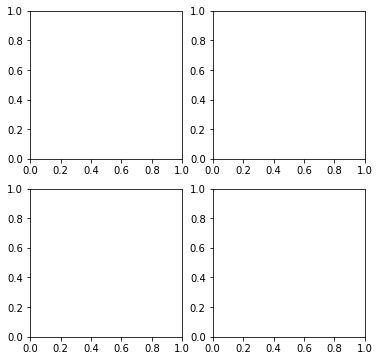

In [47]:
one_min_tester.visualise_result([0,1])

## 5 minute horizon

In [13]:
horizon = 5
theta_model = ThetaModel(horizon, 30)

In [14]:
five_min_tester = ModelTester(data, theta_model, horizon, 0.20)

In [15]:
speed_up_calc(five_min_tester, data, horizon)

Progress: [####################] 100.0%
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(3995, 5) (3995, 5)


In [16]:
one_min_tester.errors

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,154.920543,225.901995,100.0,200.0,0.873120,7.87091,1.038739
window_1_1,159.025808,229.341079,100.0,200.0,0.833926,6.32760,0.953061
window_1_2,254.259513,372.972646,100.0,200.0,0.683598,-5.65328,0.994533
window_1_3,304.010671,418.925861,100.0,200.0,0.755802,-3.27174,1.068237
window_1_4,281.154709,434.624537,100.0,200.0,1.503620,-2.16306,0.987490
window_1_5,275.414725,405.734780,100.0,200.0,2.194102,-3.37388,0.934308
window_1_6,353.857882,444.584648,100.0,200.0,0.852117,1.01895,0.876046
window_1_7,332.306383,375.557776,100.0,200.0,1.132992,5.19103,0.954848
window_1_8,382.085785,434.538429,100.0,200.0,0.968736,-2.69256,1.036801
window_1_9,351.827535,435.486561,100.0,200.0,0.911650,-17.10632,1.004688


## 60 minute horizon

In [17]:
horizon = 60
theta_model = ThetaModel(horizon, 120)

In [18]:
sixty_min_tester = ModelTester(data, theta_model, horizon, 0.20)

In [19]:
speed_up_calc(sixty_min_tester, data, horizon)

Progress: [####################] 100.0%
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3900, 60) (3900, 60)


In [20]:
sixty_min_tester.errors

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,153.484131,225.950530,100.0,200.0,0.865024,7.79793,1.038727
window_1_1,155.153325,224.840340,100.0,200.0,0.813619,6.17352,0.950232
window_1_2,250.061593,370.004268,100.0,200.0,0.672311,-5.55994,0.996129
window_1_3,298.167396,413.794165,100.0,200.0,0.741275,-3.20886,1.078680
window_1_4,284.295754,437.703195,100.0,200.0,1.520418,-2.18722,0.988257
window_1_5,279.136811,409.948047,100.0,200.0,2.223754,-3.41947,0.940083
window_1_6,351.067234,443.905055,100.0,200.0,0.845397,1.01092,0.864765
window_1_7,333.884514,377.522610,100.0,200.0,1.138373,5.21569,0.958413
window_1_8,385.862329,438.030790,100.0,200.0,0.978311,-2.71918,1.027448
window_1_9,356.846223,439.711197,100.0,200.0,0.924654,-17.35034,1.005336


In [81]:
r_data[0]

35.753000,35.679000,35.606000,35.532000,...,31.748000,31.679000,31.610000,31.541000


In [82]:
r_data[0][:60]

35.753000,35.679000,35.606000,35.532000,...,31.748000,31.679000,31.610000,31.541000


In [83]:
theta_forecast_results = thetaModel.dotm(r_data[0], h=5, level=FloatVector([40, 60, 80]), estimation=True)
# theta_forecast_results = thetaModel.dotm(r_data[0], h=5, level=FloatVector([40, 60, 80]), par_ini=FloatVector([r_data[0]/2, 0.5, 2], estimation=True))

# theta_forecast_results = thetaModel.otm.arxiv(r_data[0], 60, approach='a', tLineExtrap='ses')

thetaOutput = dict(zip(theta_forecast_results.names, map(list,list(theta_forecast_results))))

In [84]:
thetaOutput.keys()

dict_keys(['method', 'y', 's', 'opt.method', 'par', 'weights', 'fitted', 'residuals', 'mean', 'level', 'lower', 'upper', 'tests'])

In [85]:
len(thetaOutput['fitted'])

60

In [86]:
plt.plot(thetaOutput['residuals'])

In [87]:
r_data[0][-1:][0]

31.541000000000157

<IPython.core.display.Javascript object>


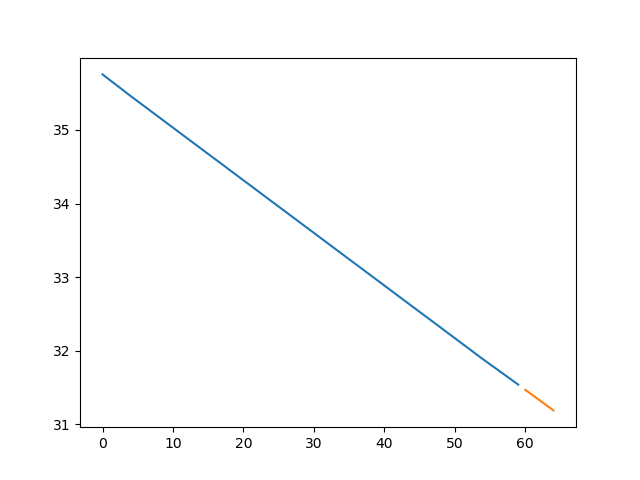

In [88]:
%matplotlib notebook
plt.plot(np.arange(60), r_data[0][:60])
plt.plot(np.arange(5) + 60, thetaOutput['mean'])
# plt.plot(1000 + np.arange(5), thetaOutput['mean'])
# plt.plot(1000 + np.arange(5), [r_data[0][-1:][0]] * 5)

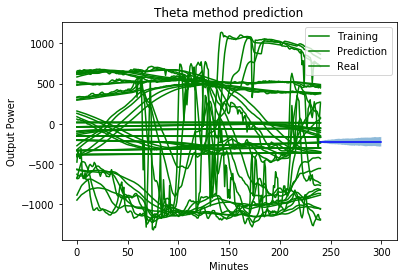

In [23]:
offset = 240
horizon = 60

plt.plot(np.linspace(0, offset, offset), data[-offset:], c = 'g')

plt.plot(np.linspace(offset, offset + horizon, horizon), thetaOutput['mean'][:horizon], c = 'b')

plt.fill_between(np.linspace(offset, offset + horizon, horizon), 
                 thetaOutput['upper'][:horizon], 
                 thetaOutput['lower'][:horizon],
                 color=None, alpha=.5)


plt.title('Theta method prediction')
plt.ylabel('Output Power')
plt.xlabel('Minutes')
plt.legend(['Training', 'Prediction', 'Real'])

In [19]:
result

R object with classes: ('thetaModel',) mapped to:
<ListVector - Python:0x0000018EEE2228C8 / R:0x0000018EEA53E7D8>
[StrVector, Array, BoolVector, StrVector, ..., FloatVector, Matrix, Matrix, Matrix]
  method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000018EEE222948 / R:0x0000018EE931B2F8>
['Dynamic Optimised Theta Model']
  y: <class 'rpy2.robjects.vectors.Array'>
  R object with classes: ('ts',) mapped to:
<Array - Python:0x0000018EEE222548 / R:0x0000018EEA513F00>
[35.753000, 35.679000, 35.606000, 35.532000, ..., -238.510000, -228.970000, -229.130000, -221.580000]
  s: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x0000018EEE153088 / R:0x0000018EE6D13DD8>
[       0]
  opt.method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000018EEE15B388 / R:0x0000018EE9317298>
['Nelder-Mead']
...
  weights: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018EEE15B088 / R:0x0000018EE7E7C4C0>
[80.000000, 90.000000, 95.000000]
  fitted: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('mts', 'ts', 'matrix') mapped to:
<Matrix - Python:0x0000018EEE153288 / R:0x0000018EEF0AB6D0>
[-229.552938, -231.201627, -233.153862, -235.388870, ..., -318.829178, -328.208060, -323.034807, -326.981292]
  residuals: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('mts', 'ts', 'matrix') mapped to:
<Matrix - Python:0x0000018EEE15B048 / R:0x0000018EEF0AC280>
[-214.368490, -210.189333, -208.788370, -205.769922, ..., -128.400237, -132.625547, -134.586285, -129.344309]
  mean: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x0000018EEE15B208 / R:0x0000018EE9CDEE78>
[0.233423, 0.000000]

#### Split to train / test

In [13]:
def split(data, splits = 10, offset = 0, ratio = 0.2):
    result = []
    
    for i in range(0, splits):
        start = int( offset + (i / splits) * (len(data) - offset)   )
        end   = int( offset + ((i + 1) / splits) * (len(data) - offset) )
        print(start, end)
        
        tempData = data[start: end]
        train, test = tempData[0: int(0.8 * len(tempData))], tempData[int(0.8 * len(tempData)):] 
        
        result.append((train, test))
        
    return result

In [14]:
splits = 20

trainingSets = split(data.values, splits, 50000)

50000 52500
52500 55000
55000 57500
57500 60000
60000 62500
62500 65000
65000 67500
67500 70000
70000 72500
72500 75000
75000 77500
77500 80000
80000 82500
82500 85000
85000 87500
87500 90000
90000 92500
92500 95000
95000 97500
97500 100000


### Parse to R

Create a 2 class classifier that seperates flat operation and irregular operation.

Find papers discussing samples required to accurately estimate H.
How many samples to be reasonable.
 - Find papers using H.
 - Look at their dataset sizes.
 - These should be a reasonable indicator of required samples.
 
 Around 20 pieces should be reasonable.

Could use MC (simulation) to generator additional data from our samples.

Text(0.5,0,'Minutes')

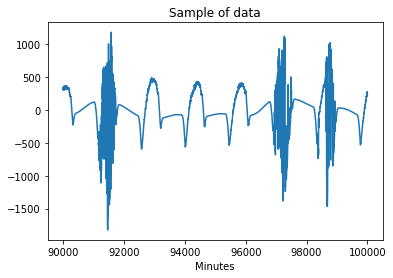

In [15]:
plt.plot(data[-10000:])
plt.title('Sample of data')
plt.ylabel('')
plt.xlabel('Minutes')

In [16]:
# Setup to parse to R
pandas2ri.activate()
ts = ro.r('ts')
forecast = importr('forecast')

thetaModel = importr('forecTheta')

In [17]:
rdata = ts(trainingSets[1][0], frequency = 1)

In [18]:
fit = forecast.auto_arima(rdata)
forecast_output = forecast.forecast(fit,h=16,level=(95.0))

In [19]:
#index = pd.date_range(start=traindf.index.max(),periods=len(forecast_output[3])+1,freq='QS')[1:]
forecastData = pd.Series(forecast_output[3])#,index=index)
lowerpi = pd.Series(forecast_output[4])#,index=index)
upperpi = pd.Series(forecast_output[5])#,index=index)

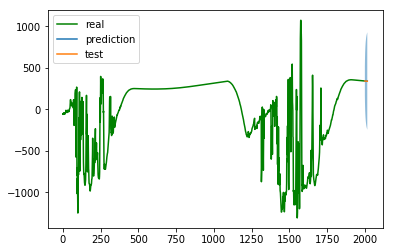

In [20]:
horizon = 16
offset  = len(trainingSets[1][0])
c = 0

plt.plot(np.linspace(0, offset, offset), trainingSets[1][0][-offset:], c='g')
plt.plot(np.linspace(offset, offset + horizon, horizon), forecastData.values[0])
plt.plot(np.linspace(offset, offset + horizon, horizon),  trainingSets[1][1][:horizon])

plt.fill_between(np.linspace(c + offset, c + offset + horizon, horizon), 
                 y1 = list(lowerpi.values[0]), 
                 y2 = list(upperpi.values[0]), color=None, alpha=.5)

plt.legend(['real', 'prediction', 'test'])

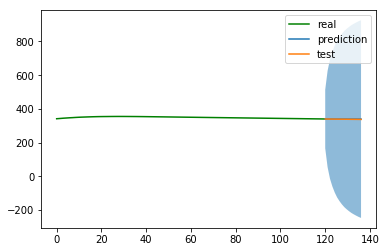

In [21]:
horizon = 16
offset  = 120
c = 0

plt.plot(np.linspace(0, offset, offset), trainingSets[1][0][-offset:], c='g')
plt.plot(np.linspace(offset, offset + horizon, horizon), forecastData.values[0])
plt.plot(np.linspace(offset, offset + horizon, horizon),  trainingSets[1][1][:horizon])

plt.fill_between(np.linspace(c + offset, c + offset + horizon, horizon), 
                 y1 = list(lowerpi.values[0]), 
                 y2 = list(upperpi.values[0]), color=None, alpha=.5)

plt.legend(['real', 'prediction', 'test'])

## Test on daytime only data

In [22]:
d = []
for i in range(0, 7):
#     plt.plot(np.linspace(i, i + 1, 0.5 * 60 * 24), dataset[int(i * 60 * 24 + 0.25 * 60 * 24) : int(i * 60 * 24 + 0.75 * 60 * 24)])
    d.append(data[int(i * 60 * 24 + 0.25 * 60 * 24) : int(i * 60 * 24 + 0.75 * 60 * 24)])
    
d = np.concatenate(d)

In [23]:
d.shape

(5040, 1)

In [24]:
rdata = ts(d[:5000], frequency = 1)

In [25]:
result = thetaModel.dotm(rdata, h=60)

thetaOutput = dict(zip(result.names, map(list,list(result))))

In [26]:
offset = 240
horizon = 60

# plt.plot(np.linspace(0, offset, offset), data[-offset:], c = 'g')

plt.plot(np.linspace(offset, offset + horizon, horizon), thetaOutput['mean'][:horizon], c = 'b')

plt.fill_between(np.linspace(offset, offset + horizon, horizon), 
                 thetaOutput['upper'][:horizon], 
                 thetaOutput['lower'][:horizon],
                 color=None, alpha=.5)


plt.title('Theta method prediction')
plt.ylabel('Output Power')
plt.xlabel('Minutes')
plt.legend(['Training', 'Prediction', 'Real'])

IndentationError: unexpected indent (<ipython-input-26-bfa0c69af47c>, line 14)

## Create Theta Model 

In [ ]:
result = thetaModel.dotm(rdata, h=60)

In [27]:
print(result)

Forecast method: Dynamic Optimised Theta Model 



Seasonal decomposition: no 



Optimisation method: Nelder-Mead 



Number of theta lines: 2 



Weights for theta lines:

        Estimative

omega_1       0.11

omega_2       0.89



Estimative of parameters:

         MLE

ell0  -50.73

alpha   0.90

theta   1.12



Forecasting points and prediction intervals

Time Series:

Start = 5001 

End = 5060 

Frequency = 1 

          Mean      Lo 80    Hi 80      Lo 90     Hi 90      Lo 95     Hi 95

5001 -143.4181  -272.6820   0.6570  -300.7604   39.3109  -331.2550   61.1357

5002 -143.4186  -352.0498  64.4331  -388.3449  144.2022  -467.4002  205.2533

5003 -143.4192  -385.3622 114.1600  -478.8707  167.4120  -523.9051  208.3926

5004 -143.4197  -432.6051 138.5795  -541.5677  226.1359  -608.3752  251.0090

5005 -143.4202  -493.9623 189.0985  -645.0577  293.6741  -676.7311  324.0481

5006 -143.4207  -526.3774 202.9083  -682.1566  310.1815  -794.6898  376.1436

5007 -143.4213  -557.7193 269.

In [28]:
result.items

<bound method Vector.items of R object with classes: ('thetaModel',) mapped to:
<ListVector - Python:0x0000022EB030D908 / R:0x0000022EB3D4EF98>
[StrVector, Matrix, BoolVector, StrVector, ..., FloatVector, Matrix, Matrix, Matrix]
  method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000022EB0432AC8 / R:0x0000022EBA72C928>
['Dynamic Optimised Theta Model']
  y: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('ts',) mapped to:
<Matrix - Python:0x0000022EB0322808 / R:0x0000022EBAB42848>
[-100.030000, -103.640000, -108.550000, -113.820000, ..., -157.070000, -152.460000, -149.820000, -142.650000]
  s: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x0000022EBB0E3188 / R:0x0000022EB0253DD8>
[       0]
  opt.method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000022EBB0E

In [29]:
type(result)

rpy2.robjects.vectors.ListVector

In [30]:
thetaOutput = dict(zip(result.names, map(list,list(result))))

In [31]:
thetaOutput.keys()

dict_keys(['method', 'y', 's', 'opt.method', 'par', 'weights', 'fitted', 'residuals', 'mean', 'level', 'lower', 'upper', 'tests'])

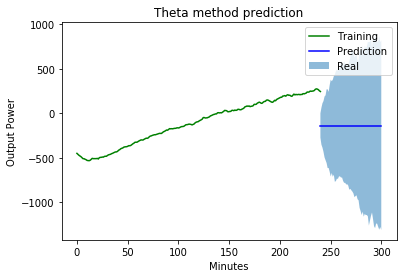

In [32]:
offset = 240
horizon = 60

plt.plot(np.linspace(0, offset, offset), data[-offset:], c = 'g')

plt.plot(np.linspace(offset, offset + horizon, horizon), thetaOutput['mean'][:horizon], c = 'b')

plt.fill_between(np.linspace(offset, offset + horizon, horizon), 
                 thetaOutput['upper'][:horizon], 
                 thetaOutput['lower'][:horizon],
                 color=None, alpha=.5)


plt.title('Theta method prediction')
plt.ylabel('Output Power')
plt.xlabel('Minutes')
plt.legend(['Training', 'Prediction', 'Real'])

## Programmatically run Theta Model

sMAPE Error:         [1] 5.336747

MAE Error:           [1] 10.14351

MAPE Error:          [1] 5.178271



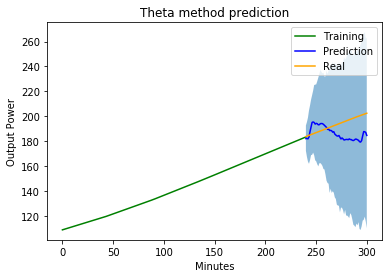

sMAPE Error:         [1] 24.69914

MAE Error:           [1] 93.37013

MAPE Error:          [1] 27.85092



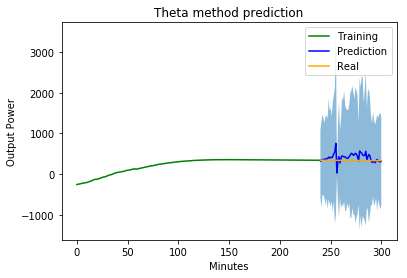

sMAPE Error:         [1] 96.06591

MAE Error:           [1] 353.3784

MAPE Error:          [1] 116.8166



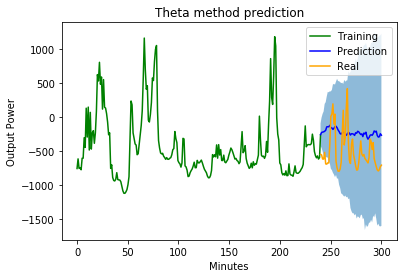

sMAPE Error:         [1] 54.01986

MAE Error:           [1] 277.1451

MAPE Error:          [1] 90.64917



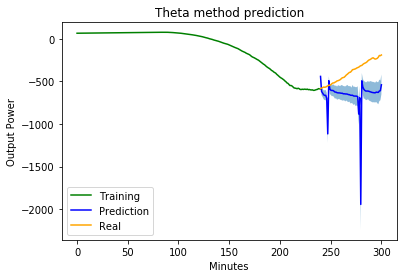

sMAPE Error:         [1] 7.902581

MAE Error:           [1] 19.93026

MAPE Error:          [1] 9.277423



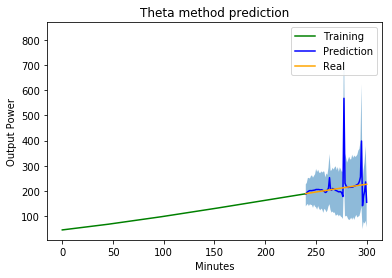

sMAPE Error:         [1] 32.47876

MAE Error:           [1] 288.2777

MAPE Error:          [1] 94.33136



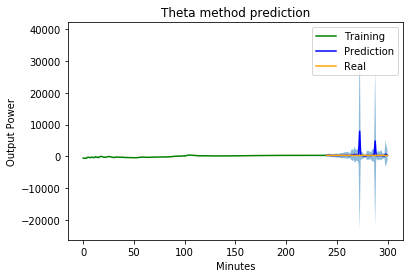

sMAPE Error:         [1] 8.976764

MAE Error:           [1] 26.18372

MAPE Error:          [1] 8.534965



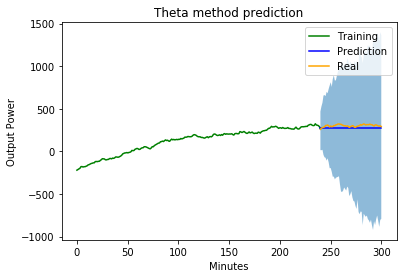

sMAPE Error:         [1] 157.9739

MAE Error:           [1] 223.185

MAPE Error:          [1] 283.6225



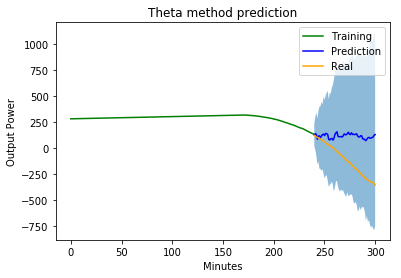

sMAPE Error:         [1] 25.339

MAE Error:           [1] 59.13724

MAPE Error:          [1] 22.0772



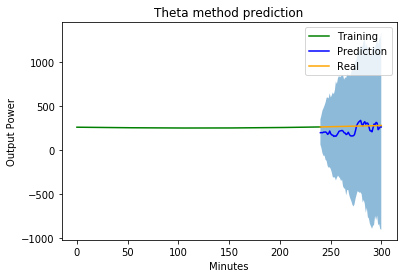

sMAPE Error:         [1] 16.84243

MAE Error:           [1] 50.02191

MAPE Error:          [1] 15.24377



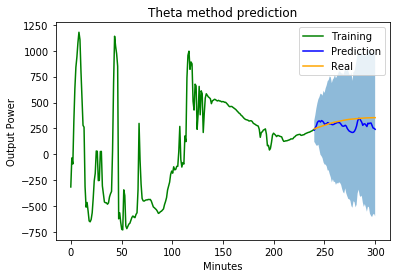

sMAPE Error:         [1] 141.9854

MAE Error:           [1] 940.0047

MAPE Error:          [1] 255.5854



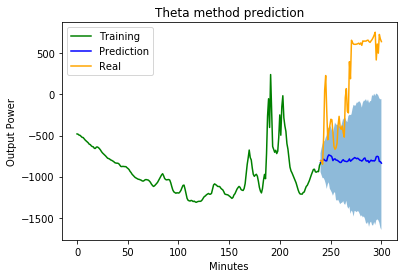

sMAPE Error:         [1] 71.16879

MAE Error:           [1] 34.27777

MAPE Error:          [1] 14345.24



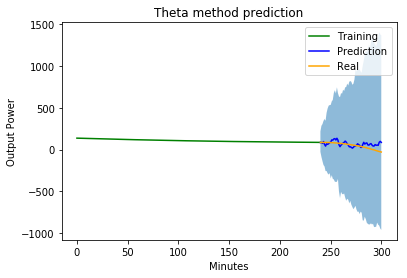

sMAPE Error:         [1] 17.09742

MAE Error:           [1] 12.74477

MAPE Error:          [1] 17.58283



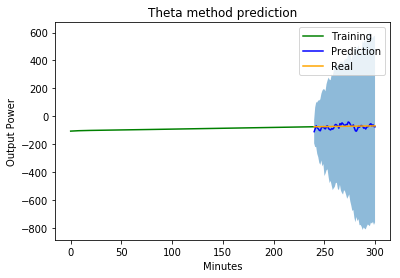

sMAPE Error:         [1] 158.2662

MAE Error:           [1] 209.3713

MAPE Error:          [1] 389.8811



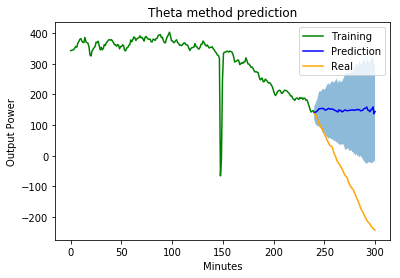

sMAPE Error:         [1] 48.09428

MAE Error:           [1] 66.16592

MAPE Error:          [1] 37.90272



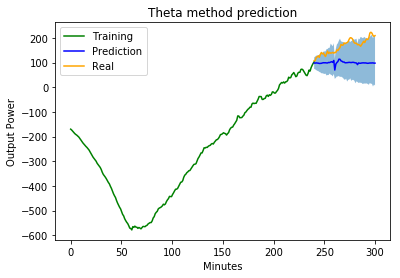

sMAPE Error:         [1] 7.86232

MAE Error:           [1] 3.140313

MAPE Error:          [1] 7.192897



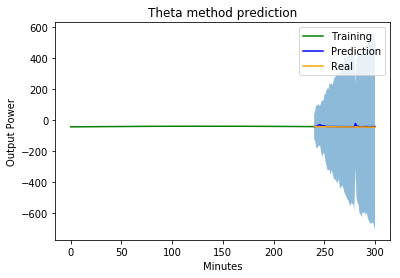

sMAPE Error:         [1] 85.16566

MAE Error:           [1] 53.54034

MAPE Error:          [1] 162.19



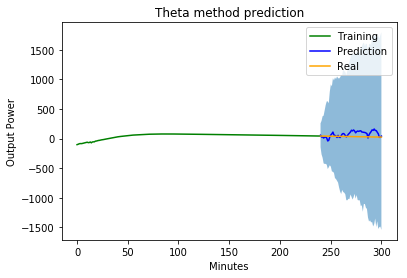

sMAPE Error:         [1] 30.65672

MAE Error:           [1] 100.5536

MAPE Error:          [1] 37.87519



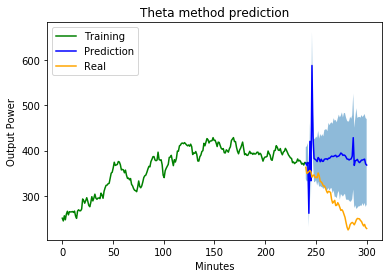

sMAPE Error:         [1] 76.78267

MAE Error:           [1] 191.994

MAPE Error:          [1] 73.98613



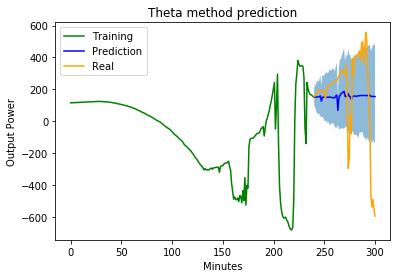

sMAPE Error:         [1] 19.98585

MAE Error:           [1] 7.805358

MAPE Error:          [1] 17.74938



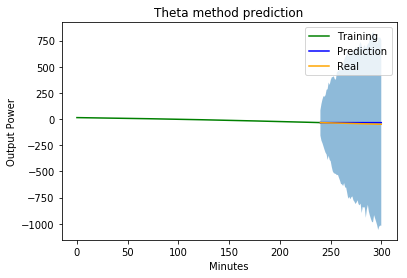

In [33]:
mae = []

c = 0
horizon = 60
freq = 60

for X_train, X_test in trainingSets:
    # Parse to R
    rTrain = ts(X_train, frequency = freq)
    rTest =  ts(X_test[:horizon], frequency = freq)
    
    # Create the forecast
#     result = thetaModel.dstm(rTrain, h = horizon) 
    result = thetaModel.dotm(rTrain, h = horizon)
   
    # par_ini=ro.r('c(5 / 2 , 0.8, 2)'))
    # , lower=ro.r('=c(80,90,95)'), upper =ro.r('=c(80,90,95)') ) #, level=ro.r('c(10)'))
    
    
    # Parse to python
    thetaOutput = dict(zip(result.names, map(list,list(result))))
    
    # Calculate the errors
    mean = ts(thetaOutput['mean'][:horizon])
    print("sMAPE Error:".ljust(20), thetaModel.errorMetric(obs = rTest, forec=mean, type = "sAPE", statistic = "M"))
    print("MAE Error:".ljust(20), thetaModel.errorMetric(obs = rTest, forec=mean, type = "AE", statistic = "M"))
    print("MAPE Error:".ljust(20), thetaModel.errorMetric(obs = rTest, forec=mean, type = "APE", statistic = "M"))

    mae.append(thetaModel.errorMetric(obs = rTest, forec=mean, type = "AE", statistic = "M"))
    
    
    # Plot results
    plt.figure()
    # Previous data
    plt.plot(np.linspace(c, c + offset, offset), X_train[-offset:], c = 'g')

    # Prediction
    plt.plot(np.linspace(c + offset, c + offset + horizon, horizon), thetaOutput['mean'][:horizon], c = 'b')
    plt.fill_between(np.linspace(c + offset, c +offset + horizon, horizon), 
                     thetaOutput['upper'][:horizon], 
                     thetaOutput['lower'][:horizon],
                     color=None, alpha=.5)
    
    # Real
    plt.plot(np.linspace(c + offset, c + offset + horizon, horizon), X_test[:horizon], c = 'orange')


    plt.title('Theta method prediction')
    plt.ylabel('Output Power')
    plt.xlabel('Minutes')
    plt.legend(['Training', 'Prediction', 'Real'])
    
    plt.show()

In [37]:
mae[0][0]

_mae = [m[0] for m in mae]

In [41]:
_mae = np.array(_mae)

In [42]:
np.average(_mae**0.5)

10.150543411178315

In [44]:
_mae

array([ 10.14351458,  93.37012766, 353.37838345, 277.14506006,
        19.93026418, 288.27772751,  26.18372435, 223.18503793,
        59.13723843,  50.02190843, 940.00471564,  34.27777373,
        12.74477313, 209.37129021,  66.16592119,   3.1403135 ,
        53.54034342, 100.55362878, 191.99402415,   7.80535809])